In [1]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Set up file read/folder structure
os.chdir("C:\\Users\\erroden\\Desktop\\ML_Guild\\mlg_02_us\\Capstone")

# Local Sources
# Initial focus will be on the airline data set but others may be stitched on to enrich the data
airline = pd.read_csv("data\\airline.csv")

airport = pd.read_csv("data\\airport.csv")
lounge = pd.read_csv("data\\lounge.csv")
seat = pd.read_csv("data\\seat.csv")

In [3]:
# Add on text length as an extra data point - https://medium.com/tensorist/classifying-yelp-reviews-using-nltk-and-scikit-learn-c58e71e962d9
airline["text_len"] = airline.content.apply(len)

airline.head()

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,...,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended,text_len
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,4/10/2015,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy,...,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1,424
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,1/5/2015,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,NaN,NaN,Business Class,...,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1,141
2,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,E Albin,Switzerland,9/14/2014,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,NaN,NaN,Economy,...,9.0,5.0,5.0,4.0,0.0,NaN,NaN,5.0,1,249
3,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Tercon Bojan,Singapore,9/6/2014,Adria serves this 100 min flight from Ljubljan...,NaN,NaN,Business Class,...,8.0,4.0,4.0,3.0,1.0,NaN,NaN,4.0,1,439
4,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,L James,Poland,6/16/2014,WAW-SKJ Economy. No free snacks or drinks on t...,NaN,NaN,Economy,...,4.0,4.0,2.0,1.0,2.0,NaN,NaN,2.0,0,675


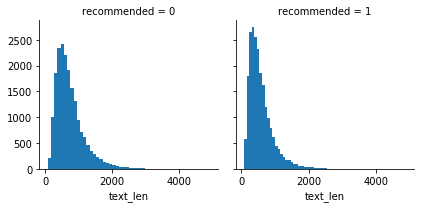

In [4]:
# visualize how words compare with recommended

g = sns.FacetGrid(data=airline, col='recommended')
g.map(plt.hist, 'text_len', bins=50)

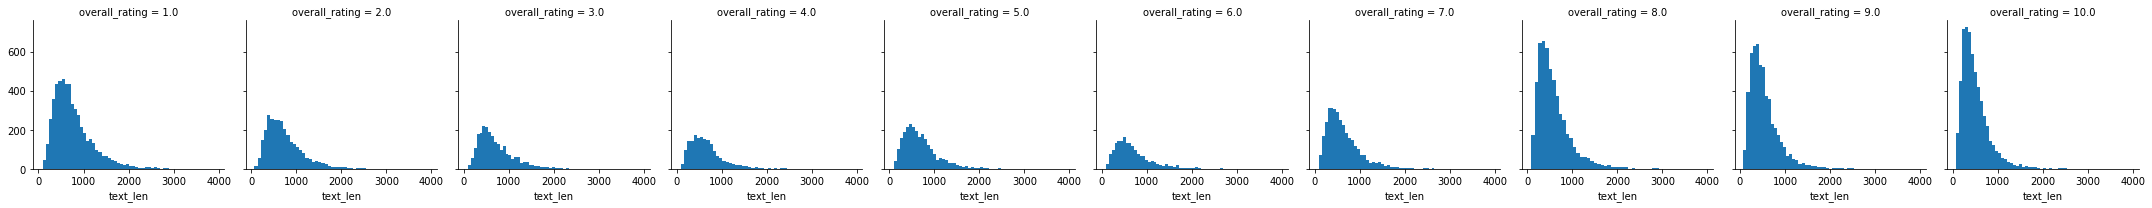

In [5]:
# visualize how words compare with recommended overall_rating

g = sns.FacetGrid(data=airline, col='overall_rating')
g.map(plt.hist, 'text_len', bins=50)

In [6]:
# generate tokens
airline['tokens'] = airline.content.apply(lambda x: x.split(" "))

airline['tokens'].head()

0    [Outbound, flight, FRA/PRN, A319., 2, hours, 1...
1    [Two, short, hops, ZRH-LJU, and, LJU-VIE., Ver...
2    [Flew, Zurich-Ljubljana, on, JP365, newish, CR...
3    [Adria, serves, this, 100, min, flight, from, ...
4    [WAW-SKJ, Economy., No, free, snacks, or, drin...
Name: tokens, dtype: object

Looks like it's off to a good start. One thing I may want to consider is pulling out specific airports too especially the three letter call signs since these should be easy to identify within the lists of tokens. 

In [7]:
stops = set(stopwords.words('english'))

In [8]:
airline['clean'] = airline['tokens'].apply(lambda x: [word for word in x if word not in stops])

In [9]:
airline['clean'] = airline['clean'].apply(lambda x: [word for word in x if re.search('^[a-zA-Z]+', word)])

In [10]:
# Lemmatizer 
lemmatizer = nltk.WordNetLemmatizer()

airline['clean'] = airline['clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [11]:
airline['ready'] =  airline['clean'].apply(lambda x: ' '.join(x))

In [12]:
# Vectorize and fit the model

from sklearn.feature_extraction.text import TfidfVectorizer

# parameters set to try to reduce features space to something that won't crash my computer
tfidf = TfidfVectorizer(max_df = .9, min_df=.05)

# running on portion of population to try to get results to work
X = tfidf.fit_transform(airline['ready'])

In [14]:
X.shape # records x tokens

(41396, 198)

In [16]:
# Classification using tfidf and recommendation as output variable

y = airline.recommended

In [17]:
# logistic regression

logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.9105464424937384

Text(0,0.5,'True Positive Rate (Sensitivity)')

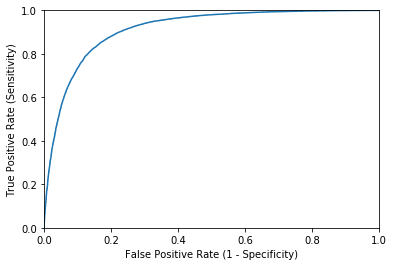

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)


fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [19]:
# Now add in sentiment

from textblob import TextBlob, Word

airline['tokens'] = airline.content.apply(lambda x: x.split(" "))

# create a text blob column 
airline['blob'] = airline.content.apply(lambda x: TextBlob(x))

In [20]:
airline.blob.head()

0    (O, u, t, b, o, u, n, d,  , f, l, i, g, h, t, ...
1    (T, w, o,  , s, h, o, r, t,  , h, o, p, s,  , ...
2    (F, l, e, w,  , Z, u, r, i, c, h, -, L, j, u, ...
3    (A, d, r, i, a,  , s, e, r, v, e, s,  , t, h, ...
4    (W, A, W, -, S, K, J,  , E, c, o, n, o, m, y, ...
Name: blob, dtype: object

In [21]:
# looks strange but seems to be correctly stored

airline.loc[0,'blob'].sentences

[Sentence("Outbound flight FRA/PRN A319."),
 Sentence("2 hours 10 min flight."),
 Sentence("I thought drinks/snacks for sale but sandwich soft drinks were served complimentary."),
 Sentence("Inbound flights SKP/LJU/FRA CRJ900."),
 Sentence("each 1 hour 30 min flight."),
 Sentence("Skyshop menu was in a seat pocket and drinks/snacks were for sale."),
 Sentence("All flight crews were friendly."),
 Sentence("Security check at the Ljubljana airport for transit passengers was chaos however it's possible to go to a gate within 30min.")]

In [22]:
# get polarity scores

airline['polarity'] = [sent.sentiment.polarity for sent in airline.blob]

In [23]:
airline.head()[['polarity', 'content']]

,polarity,content
0,0.193750,Outbound flight FRA/PRN A319. 2 hours 10 min f...
1,0.396111,Two short hops ZRH-LJU and LJU-VIE. Very fast ...
2,0.476667,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...
3,0.209091,Adria serves this 100 min flight from Ljubljan...
4,0.147222,WAW-SKJ Economy. No free snacks or drinks on t...


In [25]:
airline.content[2] # looking at the first 5 this was the most positive review and the content matches the sentiment

'Flew Zurich-Ljubljana on JP365 newish CRJ900. Flight almost full departure on time. Service on board by 2 pleasant and friendly female flight attendants. I bought coffee mineral water and a very nice and fresh filled croissant for EUR 6. Good value!'

In [26]:
# logistic regression using sentiment/polarity only

X = airline.polarity
X = X.values.reshape(-1,1)
y = airline.recommended

logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.8696651736369718

This performed slightly worse than using just the tfidf

Text(0,0.5,'True Positive Rate (Sensitivity)')

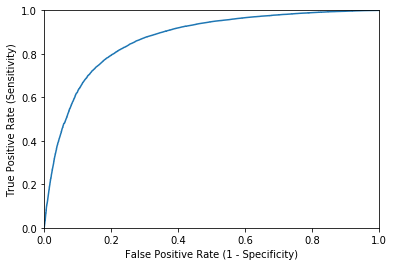

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)


fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

**Sentiment alone performs more poorly than using a tfidf, but not terrible performance

*What if we use both?

In [28]:
# parameters set to try to reduce features space to something that won't crash my computer
tfidf = TfidfVectorizer(max_df = .9, min_df=.05)

# running on portion of population to try to get results to work
X = tfidf.fit_transform(airline['ready'])

In [29]:
X.polarity = airline.polarity

In [30]:
'''
Would I want to normalize this data now? I think not because I don't believe a distance measure is applied.
'''

"\nWould I want to normalize this data now? I think not because I don't believe a distance measure is applied.\n"

In [31]:
# without normalization
logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.9105464424937384

In [33]:
# with normalization - no change so not needed
from sklearn.preprocessing import normalize 

logreg = LogisticRegression()
cross_val_score(logreg, normalize(X), y, cv=5, scoring='roc_auc').mean()

0.9105464424937384

Text(0,0.5,'True Positive Rate (Sensitivity)')

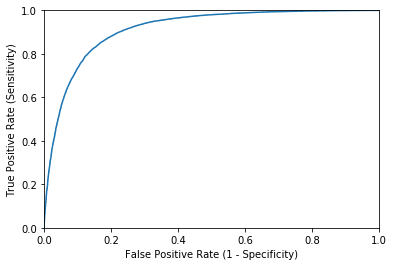

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)


fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

Similar performance to just using the tfidf

Now lets add additional features to the feature set 

In [43]:
airline.columns

Index(['airline_name', 'link', 'title', 'author', 'author_country', 'date',
       'content', 'aircraft', 'type_traveller', 'cabin_flown', 'route',
       'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating',
       'food_beverages_rating', 'inflight_entertainment_rating',
       'ground_service_rating', 'wifi_connectivity_rating',
       'value_money_rating', 'recommended', 'text_len', 'tokens', 'clean',
       'ready', 'blob', 'polarity'],
      dtype='object')

In [35]:
'''
Select only columns we are interested in. These are the columns with sufficient data. 
Cabin flown is the only categorical that could be turned into a dummy variable and added but is not considered in this iteration 
'''


airline_filtered = airline[['overall_rating','seat_comfort_rating','cabin_staff_rating',
                            'food_beverages_rating', 'inflight_entertainment_rating',
                            'text_len', 'value_money_rating', 'polarity','ready', 'recommended']]

In [36]:
airline_filtered.shape

(41396, 10)

In [37]:
airline_filtered.dropna(inplace=True)

airline_filtered.shape

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(28341, 10)

In [38]:
# generate tfidf
tfidf = TfidfVectorizer(max_df = .9, min_df=.05)

# running on portion of population to try to get results to work
X = tfidf.fit_transform(airline_filtered['ready'])

In [39]:
# Add additional columns to be included in the model

X.over_all_rating = airline_filtered.overall_rating
X.seat_comfort_rating = airline_filtered.seat_comfort_rating
X.cabin_staff_rating = airline_filtered.cabin_staff_rating
X.food_beverages_rating = airline_filtered.food_beverages_rating
X.inflight_entertainment_rating = airline_filtered.inflight_entertainment_rating
X.text_len = airline_filtered.text_len
X.value = airline_filtered.value_money_rating
X.polarity = airline_filtered.polarity

y = airline_filtered.recommended

logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()

0.9259282882745665

Text(0,0.5,'True Positive Rate (Sensitivity)')

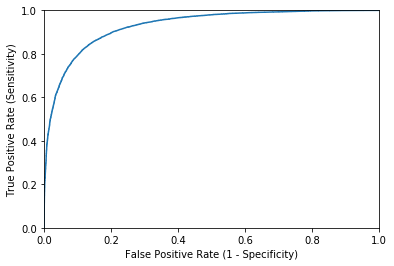

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)

fpr, tpr, thresholds = metrics.roc_curve(y, logreg.predict_proba(X)[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

This is the best model yet. Additional algorithms should be tested and other approaches to handling missing data could be implemented. Also may want to focus in on just text since that could be more useful for doing things like scraping tweets. Additionally I should consider which measures are most valuable. In theory the false postives (incorrectly predicted would recommend) are the most detrimental because it represents the business an airline wouldn't take action to save are letting walk away. 